# PyTorch - Autograd (is what we need.)

Advanced Learning 2024





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 211908942
~~~

~~~
STUDENT GIT LINK: https://github.com/omri2461/advance_comp_learning_52025
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2024_ID_[211908942].html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cuda!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [ ]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

 $$\text{median_house_value}_i=y_i = \beta_0+\beta_1\text{housing_median_age}_i+ \beta_2\text{total_rooms}_i+ \beta_3\text{total_bedrooms}_i+ \beta_4\text{population}_i+ \beta_5\text{households}_i+ \beta_6\text{median_income}_i $$

**Our loss :**  
$$
L_i(y_i,\hat{y}_i) = MSE(y_i,\hat{y}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propagation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [ ]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']

print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [ ]:
#### SOLUTION REQUIRED ####
t1 = time.time()
weights_rounded = np.linalg.inv(X.T @ X) @ X.T @ Y
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.022
The estimated weights using the analytic solution:
 [ 0.     0.204 -0.375  0.362 -0.347  0.422  0.79 ]


Visualizing the errors:

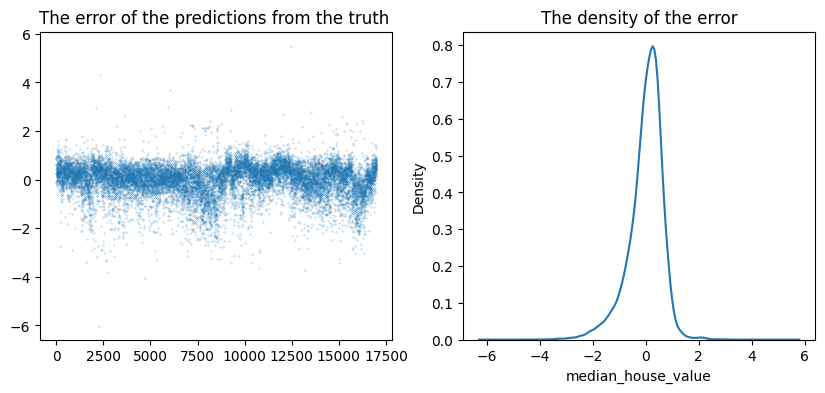

In [ ]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      



In [ ]:
#### SOLUTION REQUIRED ####

t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.randn()
b1 = np.random.randn()
b2 = np.random.randn()
b3 = np.random.randn()
b4 = np.random.randn()
b5 = np.random.randn()
b6 = np.random.randn()

# Set learning rate
learning_rate = 1e-4

# Set number of epochs:
epochs = int(5e3)

N = len(Y)
for t in range(epochs):
    # Forward pass: compute predicted y
    Y_pred = b0*X[:,0] + b1*X[:,1] + b2*X[:,2] + b3*X[:,3] + b4*X[:,4] + b5*X[:,5] + b6*X[:,6]

    # Compute and print loss (MSE)
    loss = ((Y_pred - Y)**2).mean()
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients
    grad_y_pred = 2*(Y_pred - Y)/N
    grad_b0 = (grad_y_pred * X[:,0]).sum()
    grad_b1 = (grad_y_pred * X[:,1]).sum()
    grad_b2 = (grad_y_pred * X[:,2]).sum()
    grad_b3 = (grad_y_pred * X[:,3]).sum()
    grad_b4 = (grad_y_pred * X[:,4]).sum()
    grad_b5 = (grad_y_pred * X[:,5]).sum()
    grad_b6 = (grad_y_pred * X[:,6]).sum()

    # Update weights
    b0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    b4 -= learning_rate * grad_b4
    b5 -= learning_rate * grad_b5
    b6 -= learning_rate * grad_b6

print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:13.54492387451377
Epoch:1000, loss:4.104803263803537
Epoch:2000, loss:1.901867114530648
Epoch:3000, loss:1.2877775395133575
Epoch:4000, loss:1.0513667190984546
Result: y_hat = 0.15485786876703464 x0 + -0.10783394856680004 x1 + -0.6419600704389062 x2 + -0.7820761554685387 x3
 + 0.6825435923629133 x4 + 0.6596418372350128 x5 + 0.44564395900730697 x6 

Total process time: 13.646
The estimated weights using the gradient descent solution:
 [ 0.155 -0.108 -0.642 -0.782  0.683  0.66   0.446]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [ ]:
#### SOLUTION REQUIRED ####

# Creating data and target tensors:
tX = torch.tensor(X)
tY = torch.tensor(Y)

t3 = time.time()

# Randomly initialize weights using PyTorch
tb0 = torch.randn((), requires_grad=False)
tb1 = torch.randn((), requires_grad=False)
tb2 = torch.randn((), requires_grad=False)
tb3 = torch.randn((), requires_grad=False)
tb4 = torch.randn((), requires_grad=False)
tb5 = torch.randn((), requires_grad=False)
tb6 = torch.randn((), requires_grad=False)

learning_rate = 1e-4
epochs = int(5e3)
N = len(tY)
for t in range(epochs):
    # Forward pass
    tY_pred = tb0*tX[:,0] + tb1*tX[:,1] + tb2*tX[:,2] + tb3*tX[:,3] + tb4*tX[:,4] + tb5*tX[:,5] + tb6*tX[:,6]
    loss = ((tY_pred - tY)**2).mean()
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss}")

    # Compute gradients
    grad_y_pred = (2*(tY_pred - tY)/N)
    grad_b0 = (grad_y_pred * tX[:,0]).sum()
    grad_b1 = (grad_y_pred * tX[:,1]).sum()
    grad_b2 = (grad_y_pred * tX[:,2]).sum()
    grad_b3 = (grad_y_pred * tX[:,3]).sum()
    grad_b4 = (grad_y_pred * tX[:,4]).sum()
    grad_b5 = (grad_y_pred * tX[:,5]).sum()
    grad_b6 = (grad_y_pred * tX[:,6]).sum()

    # Update weights
    tb0 = tb0 - learning_rate * grad_b0
    tb1 = tb1 - learning_rate * grad_b1
    tb2 = tb2 - learning_rate * grad_b2
    tb3 = tb3 - learning_rate * grad_b3
    tb4 = tb4 - learning_rate * grad_b4
    tb5 = tb5 - learning_rate * grad_b5
    tb6 = tb6 - learning_rate * grad_b6

print(f"Result: y_hat = {tb0} x0 + {tb1} x1 + {tb2} x2 + {tb3} x3\n + {tb4} x4 + {tb5} x5 + {tb6} x6 \n")
print(f"Total process time: {round(time.time() - t3,3)}")

weights_gd_tensors_rounded = np.array([tb0.item(),tb1.item(),tb2.item(),tb3.item(),
                                       tb4.item(),tb5.item(),tb6.item()])
print(f"The estimated weights using the gradient descent on tensors:\n {weights_gd_tensors_rounded.round(3)}")

epoch:0, loss:4.431246622078523
epoch:1000, loss:3.0587891509852154
epoch:2000, loss:2.2426053717996255
epoch:3000, loss:1.7064691551448687
epoch:4000, loss:1.3412070415827038
Result: y_hat = 0.5445552992867423 x0 + -0.3117386786701223 x1 + -0.05524541032750257 x2 + -0.4623287820155697 x3
 + 0.18218388945293648 x4 + 0.2305994677834232 x5 + 0.5080013226788865 x6 

Total process time: 4.344
The estimated weights using the gradient descent on tensors:
 [ 0.545 -0.312 -0.055 -0.462  0.182  0.231  0.508]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [ ]:
# FILL IN THE MISSING CODE

t4 = time.time()

# Initialize a single parameter vector (7 parameters) with requires_grad=True
tb = torch.randn(7, dtype=torch.double, requires_grad=True)

learning_rate = 1e-4
epochs = int(5e3)

for t in range(epochs):
    # Forward pass
    tY_pred = tX @ tb
    loss = ((tY - tY_pred)**2).mean()
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backward pass
    loss.backward()

    with torch.no_grad():
        tb -= learning_rate * tb.grad
        tb.grad = None

print(f"Result: betas = {tb} \n")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.cpu().detach().numpy()
print(f"The estimated weights using the pytorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:2.511006173603638
epoch:1000, loss:1.8768130869254271
epoch:2000, loss:1.4562001849819564
epoch:3000, loss:1.1683005147606331
epoch:4000, loss:0.9688609581544813
Result: betas = tensor([-0.3547, -0.2954, -0.7815, -0.7216, -0.1502,  1.4929,  0.7503],
       device='cuda:0', dtype=torch.float64, requires_grad=True) 

Total process time: 3.703
The estimated weights using the pytorch autograd:
 [-0.355 -0.295 -0.782 -0.722 -0.15   1.493  0.75 ]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicable?

2. Why did we scale the data?
   
3. Do you think our model specification produced good results?

4. What can you say about the total process times between methods?

5. Can you suggest some improvements to the model definition?

6. Can you suggest some improvements to the solution algorithm?



YOUR ANSWERS HERE

1. **Answer:** The analytic solution via the normal equation `(X^T X)^{-1} X^T Y` typically gives the most accurate and exact solution for linear regression under standard assumptions. It's the closed-form solution and doesn't rely on iterative approximation. However, it's not always applicable or efficient for very large datasets due to the computational cost of matrix inversion (and potential numerical instability). In large-scale problems, iterative methods (like gradient descent) are often preferred.
2. **Answer:** Scaling the data ensures that all features are on a similar scale, which helps gradient-based optimization methods converge faster and more reliably. Without scaling, some features might dominate the gradient, leading to slow convergence or poor numerical stability.
3. **Answer:** Our model is a simple linear model with no interactions or nonlinearities. Real-world housing prices are influenced by complex relationships, so a simple linear regression might not capture these complexities well. The model may not produce "great" results, but as a baseline, it's useful.
4. **Answer:** The analytic solution can be very fast for small to moderate datasets but can become expensive for very large ones due to the matrix inversion. Gradient-based methods are typically slower per iteration but can handle large datasets and high-dimensional problems more efficiently. Autograd-based methods have overhead due to graph building but are essential for deep learning.
5. **Answer:** We could add nonlinear transformations of features, interaction terms, or use a more flexible model (e.g., neural networks or tree-based methods). Regularization (like Ridge or Lasso) could also improve the model's generalization.
6. **Answer:** For gradient-based methods, we could use more sophisticated optimizers like Adam or RMSProp. We could also implement mini-batch gradient descent and early stopping. For the analytic solution, if the dataset is huge, approximate methods or iterative solvers (like conjugate gradient) could be used instead of direct matrix inversion.


PART 2: Coming soon...